In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_recall_curve, auc

In [2]:
BASE_DIR = "./dataset_balanced/"
CSV_PATH = os.path.join(BASE_DIR, "new_labels.csv")

IMAGE_DIR = os.path.join(BASE_DIR, "resized_images", "resized_images")
IMAGE_FILES = {os.path.basename(f): f for f in glob.glob(os.path.join(IMAGE_DIR, "*.png"))}

print(f"Total images found: {len(IMAGE_FILES)}")

Total images found: 51382


In [5]:
# Load CSV and extract relevant columns
df = pd.read_csv(CSV_PATH)

# Column names
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
          'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
          'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
          'Pneumothorax']

# Ensure the 'Path' column is used for image paths
df = df[['Path'] + labels]

# Optional: Add a column to indicate rows with any label
df['has_label'] = df[labels].sum(axis=1)

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# With augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
)

# Add the 'path' column to train_df and val_df
train_df['path'] = train_df['Path'].map(IMAGE_FILES)
val_df['path'] = val_df['Path'].map(IMAGE_FILES)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=False
)

Found 41105 validated image filenames.
Found 10277 validated image filenames.


In [11]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(labels), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [12]:
from keras.callbacks import ReduceLROnPlateau
# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Checkpoint and logging paths
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
checkpoint_path = "./output/thoracic_classifierV8.keras"
log_path = "./output/training_log.csv"

# Callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    save_weights_only=False,
    verbose=1
)

csv_logger = tf.keras.callbacks.CSVLogger(log_path, append=False)

# Unfreeze top layers of base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        "binary_accuracy",
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC()
    ]
)

# Train the model
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[lr_scheduler, checkpoint_callback, csv_logger, early_stopping]
)


Epoch 1/20
 138/2570 [>.............................] - ETA: 19:36 - loss: 0.3261 - binary_accuracy: 0.8971 - recall_1: 0.0085 - precision_1: 0.1718 - auc_1: 0.5986

KeyboardInterrupt: 

495/495 [==============================] - 156s 312ms/step


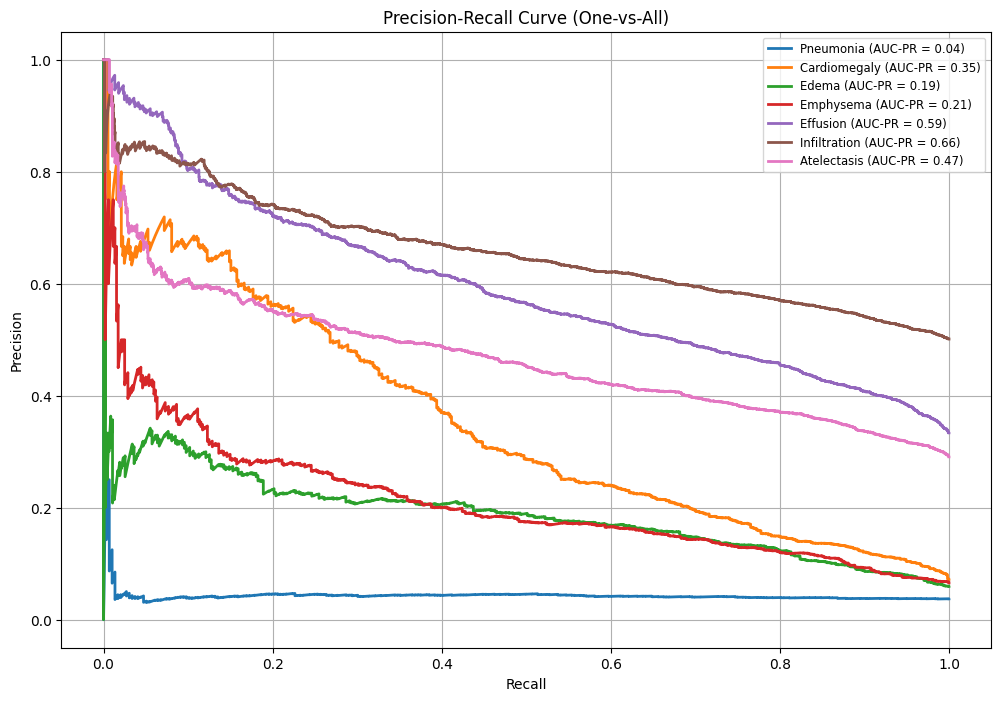

In [ ]:
# True and predicted labels
y_true = val_gen.labels
y_pred = model.predict(val_gen)

# Compute Precision-Recall and AUC-PR for each class
precision = dict()
recall = dict()
auc_pr = dict()

for i in range(len(labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Plot
plt.figure(figsize=(12, 8))
for i in range(len(labels)):
    plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} (AUC-PR = {auc_pr[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-All)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
data = pd.read_csv(log_path)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(data['epoch'], data['binary_accuracy'], label='Training Accuracy', marker='o')
plt.plot(data['epoch'], data['val_binary_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(data['epoch'], data['loss'], label='Training Loss', marker='o')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss ')
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred[:5]


from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc = 0
for (idx, c_label) in enumerate(selected_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc += auc(fpr, tpr)

mean_auc /= 15
print(mean_auc)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

In [ ]:
model.save('thoracic_classifierV8.h5')  # Saves as HDF5 format
model.save('thoracic_classifierV8.keras')  # Saves as Keras format

## Testing the Model

1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2471523..1.9973567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5011357..2.4749682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5011357..2.4749682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2471523..1.9973567].



Image 1 probabilities:
Pneumonia: 17.22%
Cardiomegaly: 1.82%
Edema: 4.83%
Emphysema: 17.12%
Effusion: 7.57%
Infiltration: 37.17%
Atelectasis: 8.81%

Image 2 probabilities:
Pneumonia: 21.90%
Cardiomegaly: 26.35%
Edema: 24.91%
Emphysema: 12.45%
Effusion: 12.23%
Infiltration: 23.10%
Atelectasis: 14.38%

Image 3 probabilities:
Pneumonia: 21.90%
Cardiomegaly: 26.35%
Edema: 24.91%
Emphysema: 12.45%
Effusion: 12.23%
Infiltration: 23.10%
Atelectasis: 14.38%

Image 4 probabilities:
Pneumonia: 17.22%
Cardiomegaly: 1.82%
Edema: 4.83%
Emphysema: 17.12%
Effusion: 7.57%
Infiltration: 37.17%
Atelectasis: 8.81%


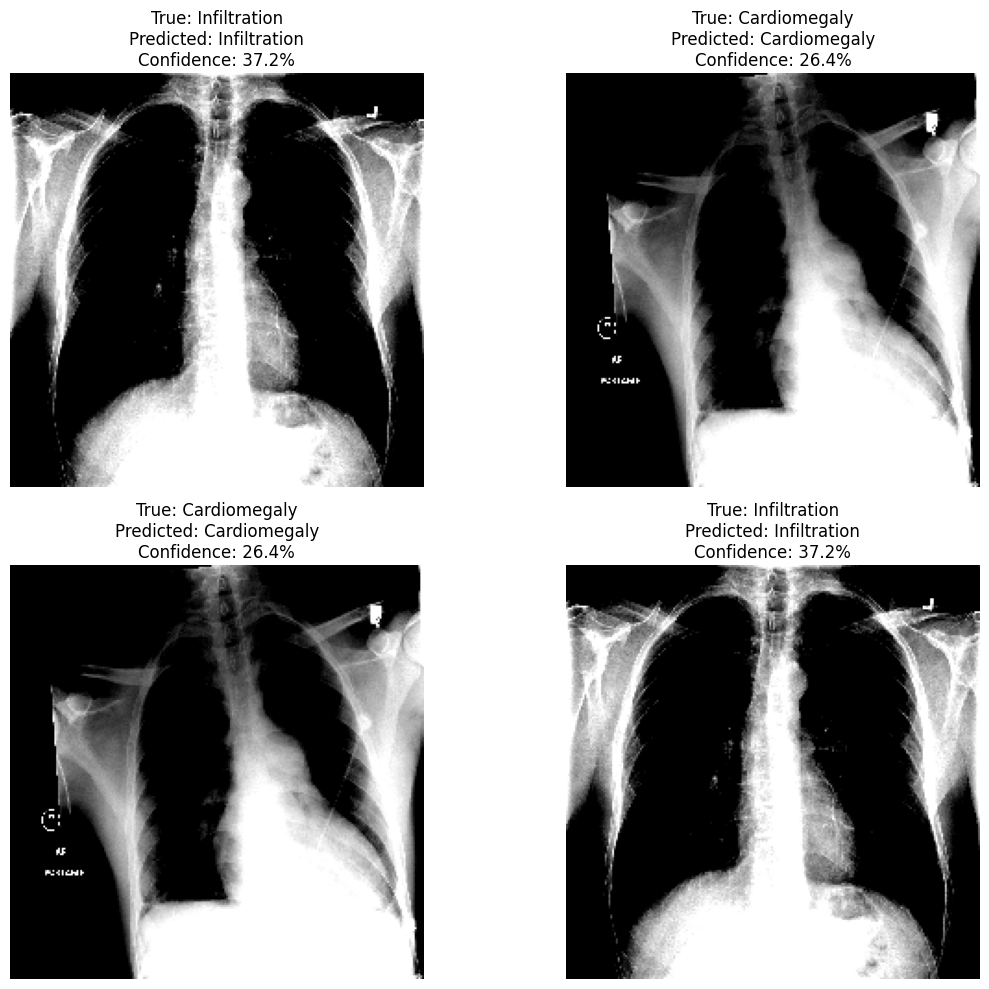

In [14]:
# Get a batch of images and labels from the validation generator
batch_images, batch_labels = next(val_gen)

# Make predictions on the batch
batch_preds = model.predict(batch_images)

# Define disease names mapping (based on your label assignments)
disease_names = ["Pneumonia", "Cardiomegaly", "Edema", 
                "Emphysema", "Effusion", "Infiltration", "Atelectasis"]

# Create a figure with 2x2 grid to display 4 random images
plt.figure(figsize=(12, 10))

# Display 4 random images from the batch
for i in range(4):
    # Choose a random image from the batch
    idx = np.random.randint(len(batch_images))
    img = batch_images[idx]
    
    # Get true and predicted labels
    true_label_idx = np.argmax(batch_labels[idx])
    pred_label_idx = np.argmax(batch_preds[idx])
    
    # Get disease names
    true_disease = disease_names[true_label_idx]
    pred_disease = disease_names[pred_label_idx]
    
    # Calculate confidence percentage
    confidence = batch_preds[idx][pred_label_idx] * 100
    
    # Plot the image in a subplot
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_disease}\nPredicted: {pred_disease}\nConfidence: {confidence:.1f}%")
    plt.axis('off')
    
    # Print detailed probabilities for this image
    print(f"\nImage {i+1} probabilities:")
    for j, disease in enumerate(disease_names):
        prob = batch_preds[idx][j] * 100
        print(f"{disease}: {prob:.2f}%")

plt.tight_layout()
plt.show()